In [257]:
import pandas as pd

# Load the dataset
df = pd.read_csv('3191936b-451e-4446-81b8-44f27652dc49.csv')

# Drop specified columns
columns_to_drop = ['MonthlyCharges', 'OnlineSecurity', 'StreamingTV', 'InternetService', 'Partner']
df_modified = df.drop(columns=columns_to_drop)

# Verify the shape
print("Modified dataset shape:", df_modified.shape)

# Save the modified dataset
df_modified.to_csv('modified_telco_churn.csv', index=False)


Modified dataset shape: (7043, 16)


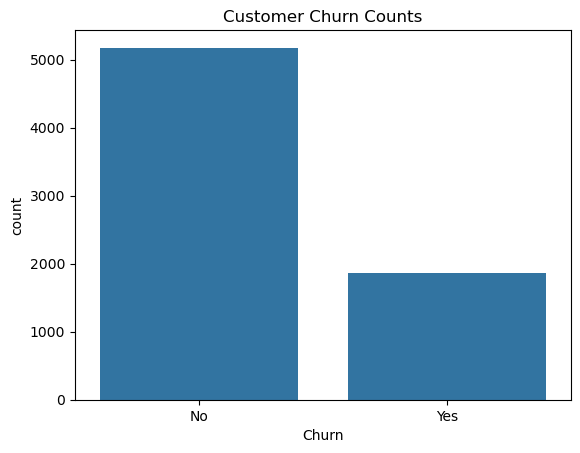

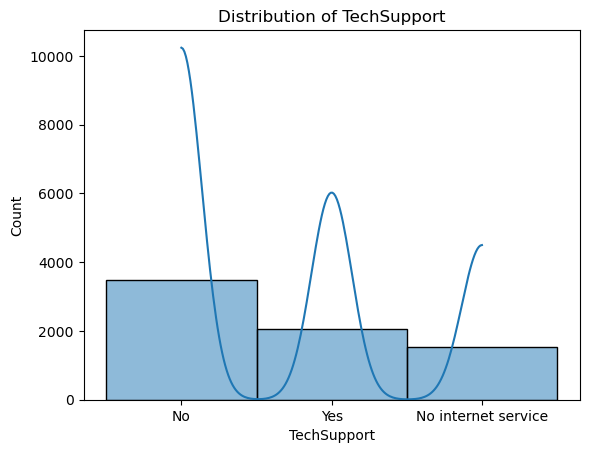

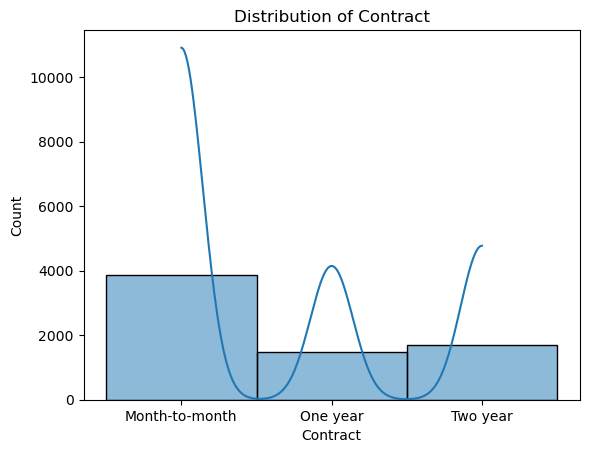

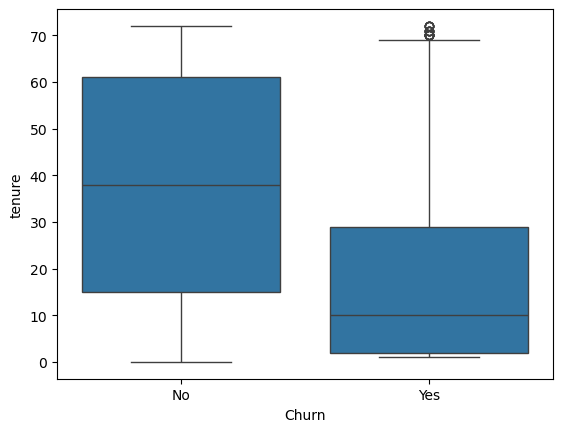

In [299]:
# Problem Statement
# Customer churn, or attrition, is a critical issue for subscription-based companies. 
# This analysis aims to build a predictive model using decision trees to help predict and address customer churn effectively.

#Exploratory Data Analysis (EDA):
df = pd.read_csv('modified_telco_churn.csv')


sns.countplot(x='Churn', data=df)
plt.title('Customer Churn Counts')
plt.show()

sns.histplot(df['TechSupport'], kde=True)
plt.title('Distribution of TechSupport')
plt.show()

sns.histplot(df['Contract'], kde=True)
plt.title('Distribution of Contract')
plt.show()

sns.boxplot(x='Churn', y='tenure', data=df)
plt.show()

In [189]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Step 1: Clean the TotalCharges column by removing non-numeric characters
df_clean = df.withColumn("TotalCharges", 
                         F.when(F.col("TotalCharges").rlike("^\d+(\.\d+)?$"), F.col("TotalCharges"))
                         .otherwise(None)
                         .cast("double"))

# Step 2: Handle missing values in TotalCharges (you can impute or drop)
df_clean = df_clean.dropna(subset=["TotalCharges"])  # Drop rows where TotalCharges is null

# Step 3: Encode categorical columns using StringIndexer
indexer_contract = StringIndexer(inputCol="Contract", outputCol="Contract_index")
indexer_online_backup = StringIndexer(inputCol="OnlineBackup", outputCol="OnlineBackup_index")
indexer_tech_support = StringIndexer(inputCol="TechSupport", outputCol="TechSupport_index")
indexer_dependents = StringIndexer(inputCol="Dependents", outputCol="Dependents_index")
indexer_paperless_billing = StringIndexer(inputCol="PaperlessBilling", outputCol="PaperlessBilling_index")

# Step 4: Convert Churn to numeric (0 or 1)
indexer_churn = StringIndexer(inputCol="Churn", outputCol="Churn_index")

# Apply transformations
df_clean = indexer_contract.fit(df_clean).transform(df_clean)
df_clean = indexer_online_backup.fit(df_clean).transform(df_clean)
df_clean = indexer_tech_support.fit(df_clean).transform(df_clean)
df_clean = indexer_dependents.fit(df_clean).transform(df_clean)
df_clean = indexer_paperless_billing.fit(df_clean).transform(df_clean)
df_clean = indexer_churn.fit(df_clean).transform(df_clean)

# Step 5: Select features
feature_columns = ["Contract_index", "OnlineBackup_index", "TechSupport_index", 
                   "Dependents_index", "PaperlessBilling_index", "TotalCharges", "tenure"]

# Step 6: Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_clean = assembler.transform(df_clean)

# Step 7: Split the data into training and testing sets
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=1234)

# Step 8: Train a Decision Tree model
dt = DecisionTreeClassifier(labelCol="Churn_index", featuresCol="features")
dt_model = dt.fit(train_data)

# Step 9: Make predictions
predictions = dt_model.transform(test_data)



In [191]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 10: Evaluate the model using different metrics

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy: ", accuracy)

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision: ", precision)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print("Recall: ", recall)

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print("F1 Score: ", f1_score)


Accuracy:  0.7824817518248175
Precision:  0.7681296704794716
Recall:  0.7824817518248176
F1 Score:  0.7569233985365585


In [195]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 1: Train Random Forest Model

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol="Churn_index", featuresCol="features")

# Train the Random Forest model
rf_model = rf.fit(train_data)

# Step 2: Make predictions with the Random Forest model
rf_predictions = rf_model.transform(test_data)

# Step 3: Evaluate Random Forest Model using different metrics

# Accuracy
rf_accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_accuracy_evaluator.evaluate(rf_predictions)
print("Random Forest Accuracy: ", rf_accuracy)

# Precision
rf_precision_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="weightedPrecision")
rf_precision = rf_precision_evaluator.evaluate(rf_predictions)
print("Random Forest Precision: ", rf_precision)

# Recall
rf_recall_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="weightedRecall")
rf_recall = rf_recall_evaluator.evaluate(rf_predictions)
print("Random Forest Recall: ", rf_recall)

# F1 Score
rf_f1_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="f1")
rf_f1_score = rf_f1_evaluator.evaluate(rf_predictions)
print("Random Forest F1 Score: ", rf_f1_score)

# Step 4: Train Logistic Regression Model

# Initialize the Logistic Regression Classifier
lr = LogisticRegression(labelCol="Churn_index", featuresCol="features")

# Train the Logistic Regression model
lr_model = lr.fit(train_data)

# Step 5: Make predictions with the Logistic Regression model
lr_predictions = lr_model.transform(test_data)

# Step 6: Evaluate Logistic Regression Model using different metrics

# Accuracy
lr_accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_accuracy_evaluator.evaluate(lr_predictions)
print("Logistic Regression Accuracy: ", lr_accuracy)

# Precision
lr_precision_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="weightedPrecision")
lr_precision = lr_precision_evaluator.evaluate(lr_predictions)
print("Logistic Regression Precision: ", lr_precision)

# Recall
lr_recall_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="weightedRecall")
lr_recall = lr_recall_evaluator.evaluate(lr_predictions)
print("Logistic Regression Recall: ", lr_recall)

# F1 Score
lr_f1_evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction", metricName="f1")
lr_f1_score = lr_f1_evaluator.evaluate(lr_predictions)
print("Logistic Regression F1 Score: ", lr_f1_score)


Random Forest Accuracy:  0.7839416058394161
Random Forest Precision:  0.7689092161776826
Random Forest Recall:  0.7839416058394161
Random Forest F1 Score:  0.7632752162369524
Logistic Regression Accuracy:  0.7912408759124088
Logistic Regression Precision:  0.7813466130022513
Logistic Regression Recall:  0.7912408759124088
Logistic Regression F1 Score:  0.7838652921786919


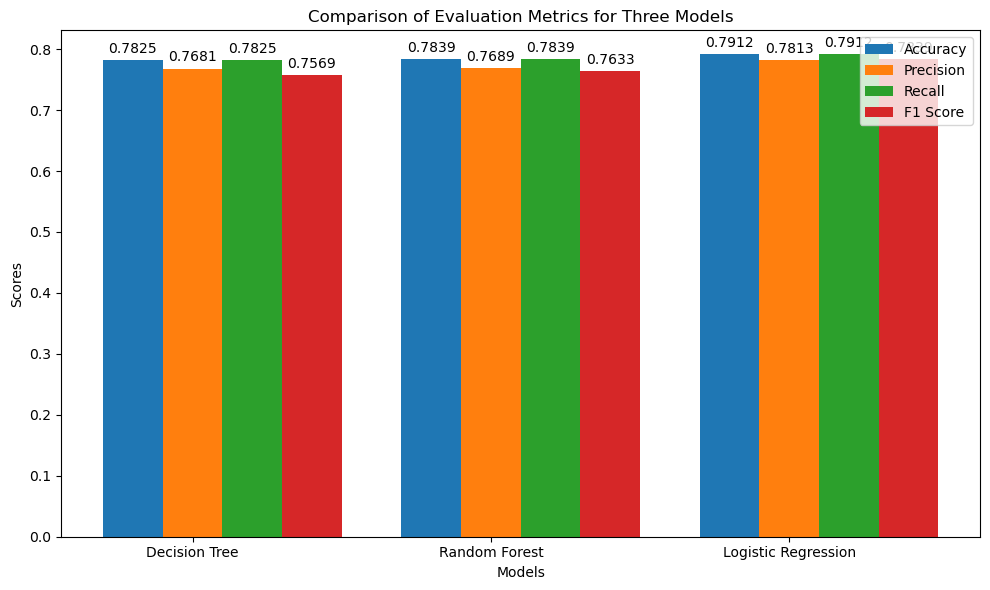

In [203]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Store the evaluation metrics for each model
models = ['Decision Tree', 'Random Forest', 'Logistic Regression']
accuracy = [0.7825, rf_accuracy, lr_accuracy]  # Replace rf_accuracy and lr_accuracy with actual values
precision = [0.7681, rf_precision, lr_precision]
recall = [0.7825, rf_recall, lr_recall]
f1_score = [0.7569, rf_f1_score, lr_f1_score]

# Step 2: Set up the bar chart
x = np.arange(len(models))  # The label locations
width = 0.2  # The width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Step 3: Create bars for each metric
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x, precision, width, label='Precision')
rects3 = ax.bar(x + width, recall, width, label='Recall')
rects4 = ax.bar(x + 2*width, f1_score, width, label='F1 Score')

# Step 4: Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics for Three Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Step 5: Function to add value labels on top of each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',  # Display values with 4 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each bar group
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

# Step 6: Show the plot
plt.tight_layout()
plt.show()


In [215]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Churn_index", metricName="areaUnderROC")

# Evaluate models
dt_auc = evaluator.evaluate(dt_roc)
rf_auc = evaluator.evaluate(rf_roc)
lr_auc = evaluator.evaluate(lr_roc)

print("Decision Tree AUC: ", dt_auc)
print("Random Forest AUC: ", rf_auc)
print("Logistic Regression AUC: ", lr_auc)


Decision Tree AUC:  0.6647443291041907
Random Forest AUC:  0.7833525567089582
Logistic Regression AUC:  0.8214148404459827


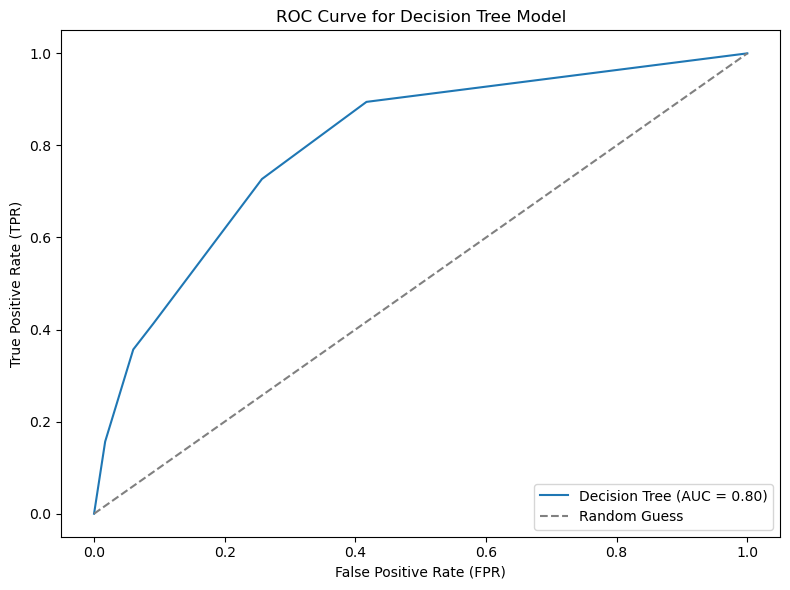

In [247]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test data
dt_predictions = dt_model.transform(test_data)

# Step 2: Extract true labels and predicted probabilities for the positive class (class 1)
y_true = [row["Churn_index"] for row in dt_predictions.select("Churn_index").collect()]
dt_pred_probs = [row["probability"][1] for row in dt_predictions.select("probability").collect()]

# Step 3: Compute the ROC curve and AUC score
dt_fpr, dt_tpr, _ = roc_curve(y_true, dt_pred_probs)
dt_auc = auc(dt_fpr, dt_tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, label="Decision Tree (AUC = {:.2f})".format(dt_auc))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")  # Diagonal line (Random Guess)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Decision Tree Model")
plt.legend(loc="lower right")

# Step 5: Show the plot
plt.tight_layout()
plt.show()

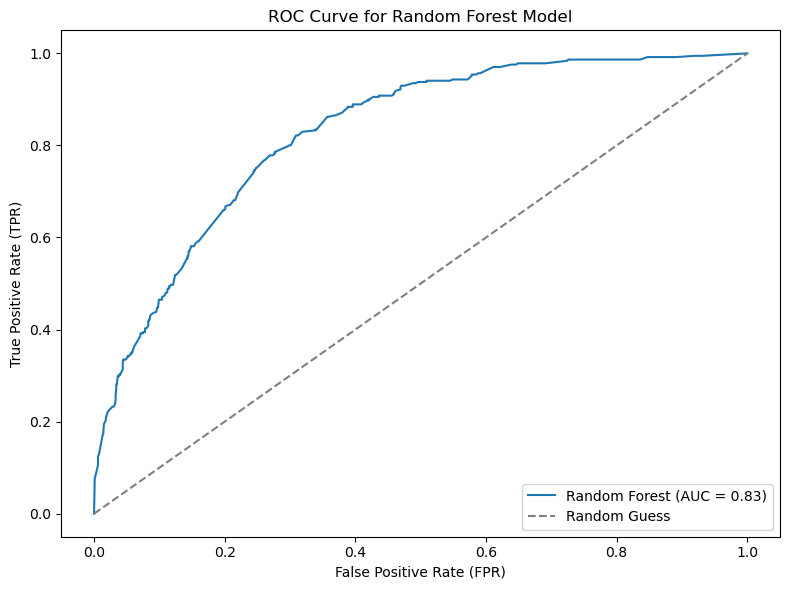

In [249]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test data with the Random Forest model
rf_predictions = rf_model.transform(test_data)

# Step 2: Extract true labels and predicted probabilities for the positive class (class 1)
y_true = [row["Churn_index"] for row in rf_predictions.select("Churn_index").collect()]
rf_pred_probs = [row["probability"][1] for row in rf_predictions.select("probability").collect()]

# Step 3: Compute the ROC curve and AUC score
rf_fpr, rf_tpr, _ = roc_curve(y_true, rf_pred_probs)
rf_auc = auc(rf_fpr, rf_tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label="Random Forest (AUC = {:.2f})".format(rf_auc))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")  # Diagonal line (Random Guess)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Random Forest Model")
plt.legend(loc="lower right")

# Step 5: Show the plot
plt.tight_layout()
plt.show()

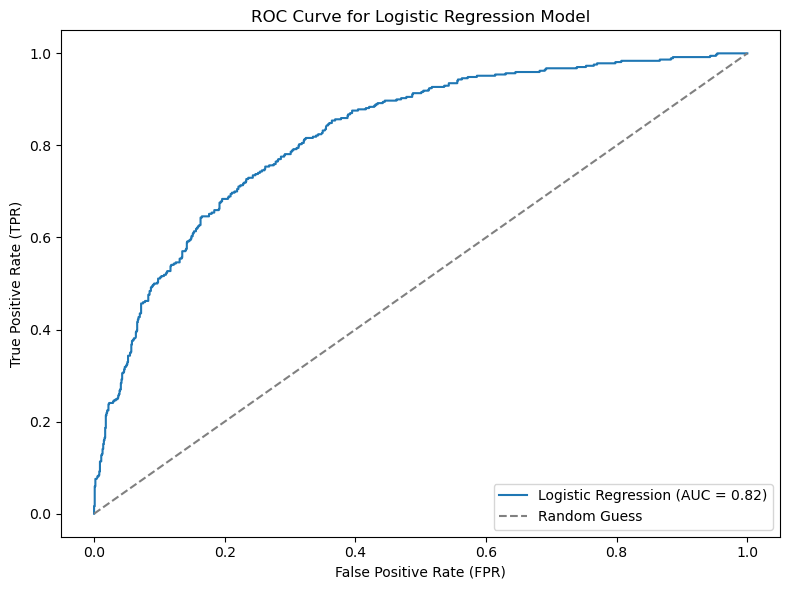

In [251]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test data with the Logistic Regression model
lr_predictions = lr_model.transform(test_data)

# Step 2: Extract true labels and predicted probabilities for the positive class (class 1)
y_true = [row["Churn_index"] for row in lr_predictions.select("Churn_index").collect()]
lr_pred_probs = [row["probability"][1] for row in lr_predictions.select("probability").collect()]

# Step 3: Compute the ROC curve and AUC score
lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_pred_probs)
lr_auc = auc(lr_fpr, lr_tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label="Logistic Regression (AUC = {:.2f})".format(lr_auc))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")  # Diagonal line (Random Guess)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Logistic Regression Model")
plt.legend(loc="lower right")

# Step 5: Show the plot
plt.tight_layout()
plt.show()

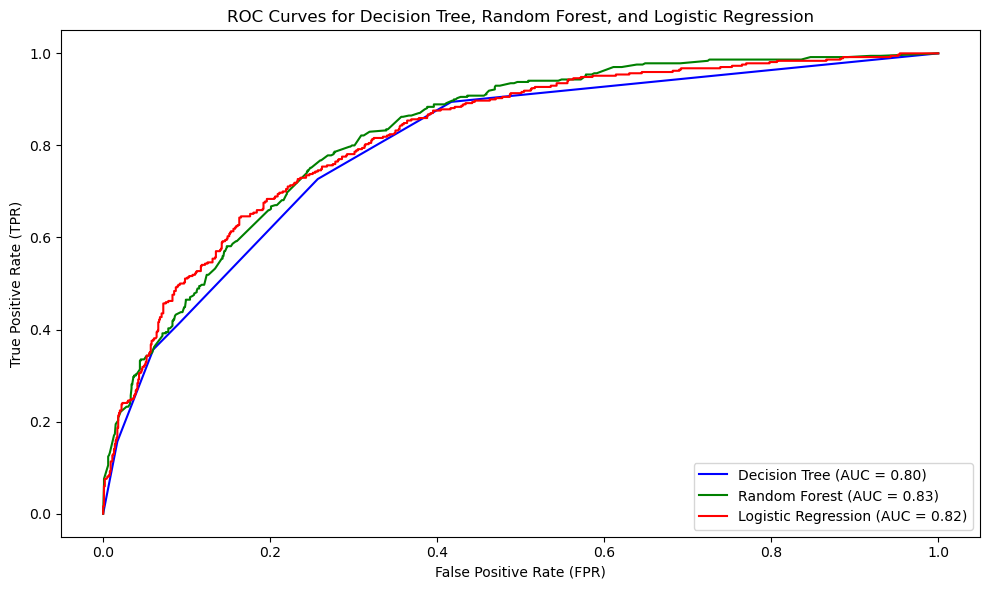

In [255]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get predictions for each model on the test data
dt_predictions = dt_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
lr_predictions = lr_model.transform(test_data)

# Step 2: Extract true labels and predicted probabilities for the positive class (class 1)
y_true = [row["Churn_index"] for row in dt_predictions.select("Churn_index").collect()]

# Decision Tree probabilities for class 1
dt_pred_probs = [row["probability"][1] for row in dt_predictions.select("probability").collect()]
dt_fpr, dt_tpr, _ = roc_curve(y_true, dt_pred_probs)
dt_auc = auc(dt_fpr, dt_tpr)

# Random Forest probabilities for class 1
rf_pred_probs = [row["probability"][1] for row in rf_predictions.select("probability").collect()]
rf_fpr, rf_tpr, _ = roc_curve(y_true, rf_pred_probs)
rf_auc = auc(rf_fpr, rf_tpr)

# Logistic Regression probabilities for class 1
lr_pred_probs = [row["probability"][1] for row in lr_predictions.select("probability").collect()]
lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_pred_probs)
lr_auc = auc(lr_fpr, lr_tpr)

# Step 3: Plot all ROC curves in one graph
plt.figure(figsize=(10, 6))

# Plot Decision Tree ROC curve
plt.plot(dt_fpr, dt_tpr, label="Decision Tree (AUC = {:.2f})".format(dt_auc), color='blue')

# Plot Random Forest ROC curve
plt.plot(rf_fpr, rf_tpr, label="Random Forest (AUC = {:.2f})".format(rf_auc), color='green')

# Plot Logistic Regression ROC curve
plt.plot(lr_fpr, lr_tpr, label="Logistic Regression (AUC = {:.2f})".format(lr_auc), color='red')


# Labels and Title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for Decision Tree, Random Forest, and Logistic Regression")
plt.legend(loc="lower right")

# Display the plot
plt.tight_layout()
plt.show()